In [33]:
# path to the root folder containg the notebook
root_path = "/content/drive/My Drive/ai/object_detection/car_detection/"
# path to the data folder
data_path = "/content/drive/My Drive/ai/object_detection/car_detection/data/"

In [34]:
import pandas as pd
# read the csv file containg the coordinates of the bounding boxes
bounding_boxes = pd.read_csv(data_path + "license_plates_detection_train.csv")
bounding_boxes.head()

,img_id,ymin,xmin,ymax,xmax
0,1.jpg,276,94,326,169
1,10.jpg,311,395,344,444
2,100.jpg,406,263,450,434
3,101.jpg,283,363,315,494
4,102.jpg,139,42,280,222


In [ ]:
from PIL import Image, ImageDraw
# get the image
image = Image.open(data_path + "images/1.jpg")
# get the bounding box
box = bounding_boxes[bounding_boxes.img_id == "1.jpg"]
xmin = box["xmin"]
ymin = box["ymin"]
xmax = box["xmax"]
ymax = box["ymax"]
draw = ImageDraw.Draw(image)
# draw the rectangle
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline = "blue")
# show an example from the dataset using Pillow
image

In [36]:
# change to the current directory
import os
os.chdir(root_path)

In [37]:
# import the required packages and libraries
import pycocotools
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [38]:
# get the coordinates of the bounding boxe for a specific image
def get_coordinates(path_to_data_file, image):
   data = pd.read_csv(data_path + "license_plates_detection_train.csv")
   boxes_array = data[data["img_id"] == image][["xmin", "ymin", "xmax", "ymax"]].values
   
   return boxes_array

In [39]:
# redefine __getitem__ and __len__ of Dataset class
class CarLicenseDataset(torch.utils.data.Dataset):
  def __init__(self, root, data_file, transforms=None):
    self.root = root
    self.transforms = transforms
    # get the name of the images using the os built-in libray
    self.imgs = sorted(os.listdir(os.path.join(root, "data", "images")))
    # path to csv file containig bounding boxes
    self.path_to_data_file = data_file
  def __getitem__(self, idx):
    # get the image path
    img_path = os.path.join(self.root, "data", "images", self.imgs[idx])
    img = Image.open(img_path).convert("RGB")
    # get the coordinates of the bounding boxe
    box_list = get_coordinates(self.path_to_data_file, self.imgs[idx])
    # convert it to tensor
    boxes = torch.as_tensor(box_list, dtype=torch.float32)
    num_objs = len(box_list)
    # we have only one class 
    labels = torch.ones((num_objs,), dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
    # define the target variable
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd
    # transform the image
    if self.transforms is not None:
      img, target = self.transforms(img, target)
    return img, target
  def __len__(self):
      return len(self.imgs)

In [40]:
def get_model(num_classes):
  # load an object detection model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the number of inputs and outputs as we need
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
  return model

In [41]:
def get_transform(train):
  transforms = []
  # converts the image into a PyTorch Tensor
  transforms.append(T.ToTensor())
  if train:
    # during training, randomly flip the training images for data augmentation
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [42]:
# defining our dataset
dataset_org = CarLicenseDataset(root= root_path,
          data_file= data_path,
          transforms = get_transform(train=True))


# split the dataset in train and test set randomly
torch.manual_seed(1)
indices = torch.randperm(len(dataset_org)).tolist()
dataset = torch.utils.data.Subset(dataset_org, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_org, indices[-40:])
# define training and test data loaders
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=4,
              collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=4,
         collate_fn=utils.collate_fn)
print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 900 examples, 860 are training and 40 testing


In [43]:
# check if we can use GPU
torch.cuda.is_available()

True

In [44]:
# use the suitable device ("gpu" or "cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only plate car - background
num_classes = 2
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# a learning rate scheduler which decreases the learning rate every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [45]:
# train for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
  # train for one epoch, printing every 10 iterations
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  # update the learning rate
  lr_scheduler.step()
  # evaluate on the test dataset
  evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/430]  eta: 0:06:48  lr: 0.000017  loss: 1.1686 (1.1686)  loss_classifier: 0.7201 (0.7201)  loss_box_reg: 0.0149 (0.0149)  loss_objectness: 0.4151 (0.4151)  loss_rpn_box_reg: 0.0184 (0.0184)  time: 0.9506  data: 0.2750  max mem: 5249
Epoch: [0]  [ 10/430]  eta: 0:05:28  lr: 0.000133  loss: 0.7760 (0.7844)  loss_classifier: 0.6004 (0.6008)  loss_box_reg: 0.0279 (0.0307)  loss_objectness: 0.0872 (0.1412)  loss_rpn_box_reg: 0.0124 (0.0116)  time: 0.7816  data: 0.0307  max mem: 7535
Epoch: [0]  [ 20/430]  eta: 0:05:00  lr: 0.000250  loss: 0.4327 (0.5322)  loss_classifier: 0.2770 (0.3916)  loss_box_reg: 0.0413 (0.0462)  loss_objectness: 0.0206 (0.0848)  loss_rpn_box_reg: 0.0085 (0.0097)  time: 0.7218  data: 0.0062  max mem: 7535
Epoch: [0]  [ 30/430]  eta: 0:04:42  lr: 0.000366  loss: 0.2001 (0.4225)  loss_classifier: 0.0988 (0.2930)  loss_box_reg: 0.0740 (0.0594)  loss_objectness: 0.0099 (0.0617)  loss_rpn_box_reg: 0.0055 (0.0083)  time: 0.6630  data: 0.0063  max mem: 7535


In [46]:
# save the model for the future use
torch.save(model.state_dict(), root_path + "model/model")

In [47]:
# use the saved model
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load(root_path + "model/model"))

<All keys matched successfully>

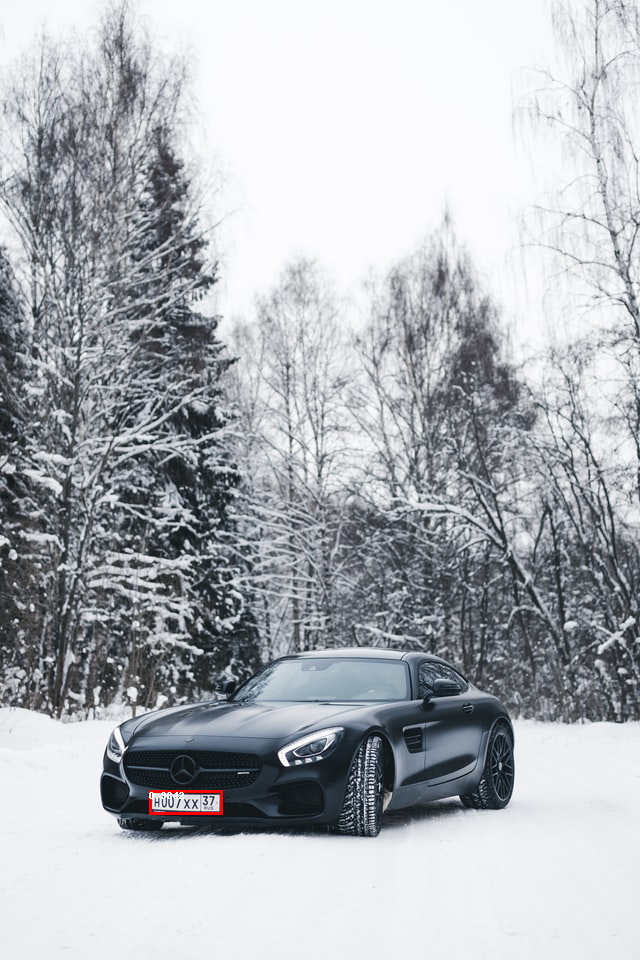

In [48]:
# path to your image here
path_to_img = data_path + "submission_images"
img = Image.open(path_to_img + "/test.jpg").convert("RGB")

# transform the image into tensor

transforms = get_transform(False)

img, _ = transforms(img, [])

# put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
  # make the prediction
  prediction = loaded_model([img])

# from tensor to image
image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(image)

# draw the predicted bounding boxes if the probability is greater than 0.8
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
   if score > 0.8:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))
image

In [49]:
print(prediction)

[{'boxes': tensor([[149.2109, 790.8679, 222.9775, 814.0055],
        [335.3997, 732.0870, 389.9753, 839.1631]]), 'labels': tensor([1, 1]), 'scores': tensor([0.9642, 0.2299])}]
